# Learning XOR

#### with pytorch

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch

In [2]:
one_d_data = np.array([0, 1])

INPUT_DATA = np.array(np.meshgrid(one_d_data, one_d_data)).T.reshape(-1, 2)
INPUT_DATA


array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [3]:
INPUT_LABEL = INPUT_DATA[:, 0] ^ INPUT_DATA[:, 1]
INPUT_LABEL

array([0, 1, 1, 0])

## Wrap around pytorch Dataset

In [4]:
from torch.utils.data import Dataset


class XORDataset(Dataset):
    def __init__(self, dimensions=2, input_range=[0, 1], output_dtype=np.float32):
        self.xx = np.array(np.meshgrid(*[input_range for _ in range(dimensions)])).T.reshape(-1, dimensions)
        self.y = np.copy(self.xx[:, 0])  # Make sure to copy data
        for i in range(1, dimensions):
            self.y ^= self.xx[:, i]
        self.output_dtype = output_dtype

    def __len__(self):
        return len(self.xx)

    def __getitem__(self, indx):
        return self.xx[indx, :].astype(self.output_dtype), self.y[indx].astype(self.output_dtype)

xor_2d_dataset = XORDataset()

In [5]:
from torch.utils.data import DataLoader

def transform(x):
    return x.float()

data_loader = DataLoader(xor_2d_dataset, batch_size=2)

batch_x, batch_y = list(data_loader)[0]
print(batch_x, batch_y)

print(batch_x.dtype)

tensor([[0., 0.],
        [0., 1.]]) tensor([0., 1.])
torch.float32


In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt

class Logger:
    def __init__(self, visual_period=100):
        self.metrics = defaultdict(list)
        self.visual_period = visual_period

    def log_metric(self, metric, label, ts):
        self.metrics[label].append((ts, metric))
        if ts % self.visual_period == self.visual_period - 1:
            plt.plot(*zip(*self.metrics[label]))
            plt.show()

    def log_image(self, *args):
        print(*args)

    def save_model(self):
        pass

In [7]:
from tqdm.notebook import tqdm
import torch


def train_loop(model, epochs, optimizer_fn, loss_fn, training_loader, validation_loader, logger):
    optimizer = optimizer_fn(model.parameters())  # Instanciate here so to reduce bugs
    for epoche_i in epochs:
        model.train()
        train_epoche(epoche_i, model, optimizer, loss_fn, training_loader, logger=logger)


def train_epoche(epoch_index, model, optimizer, loss_fn, training_loader, logger):
    running_loss = 0.
    for i, (inputs, labels) in enumerate(training_loader):

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    logger.log_metric(running_loss, 'Loss/train', epoch_index)

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


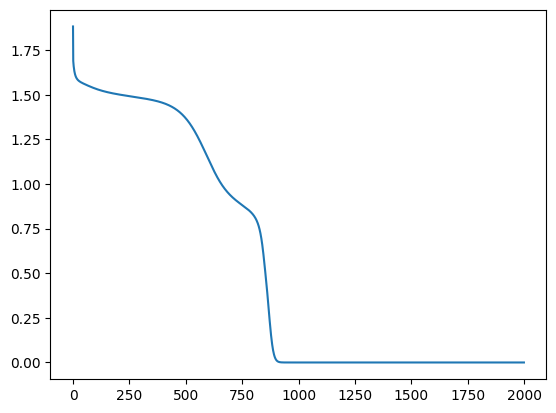

In [8]:

## TRAINING IN A SEPARATE CELL FOR PURPOSE (ideally should be a function)
torch.manual_seed(420)

from functools import partial
from torch import nn
import torch


class TwoLayerMLP(nn.Sequential):
    def __init__(self, input_dim, middle_dim=None, activation_layer=nn.Sigmoid):
        layers = [
            nn.Linear(input_dim, middle_dim or input_dim, bias=True),
            activation_layer(),
            nn.Linear(middle_dim or input_dim, 1, bias=True),
        ]
        super().__init__(*layers)

_EPOCHS = 2_000
_DIMENSION = 2

model = TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2)   # Square 2 x 2 network

xor_2d_dataset = XORDataset(dimensions=2)

sgd_with_lr_02 = partial(torch.optim.SGD, lr=0.2)

mse_loss_fn = nn.MSELoss()

train_loop(model,
           list(range(0, 1 + _EPOCHS)),
            sgd_with_lr_02,
            mse_loss_fn,
            DataLoader(xor_2d_dataset, batch_size=1, shuffle=False),
            None,
            Logger(visual_period=_EPOCHS))

In [9]:

valid_loader = DataLoader(xor_2d_dataset, batch_size=len(xor_2d_dataset), shuffle=False)
[[x, y]] = list(valid_loader)
np.vstack([model(x).detach().numpy().squeeze(), y.numpy()]).T

array([[1.7881393e-07, 0.0000000e+00],
       [9.9999994e-01, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [5.9604645e-08, 0.0000000e+00]], dtype=float32)

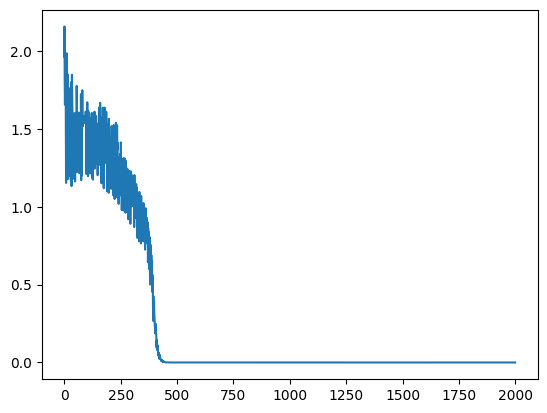

In [10]:

torch.manual_seed(420)
model = TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2)   # Square 2 x 2 network

train_loop(model,
           list(range(0, 1 + _EPOCHS)),
            sgd_with_lr_02,
            mse_loss_fn,
            DataLoader(xor_2d_dataset, batch_size=1, shuffle=True),
            None,
            Logger(visual_period=_EPOCHS))

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


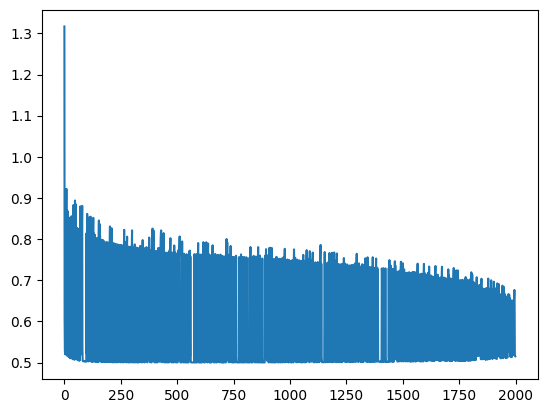

In [11]:


torch.manual_seed(420)

train_loop(
    TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2),
    list(range(0, 1 + _EPOCHS)),
    sgd_with_lr_02,
    mse_loss_fn,
    DataLoader(xor_2d_dataset, batch_size=2, shuffle=True),
    None,
    Logger(visual_period=_EPOCHS),
)

## Oops what happened? it doesn't train with batch size = 2!!!!

The problem is that it calculated the gradient for 2 differnet elements, that want to move the weights in different directions!!! (TODO: visualize)

## Something else to investigate in the future is why it doesn't learn with ReLU instead of sigmoid!!!??

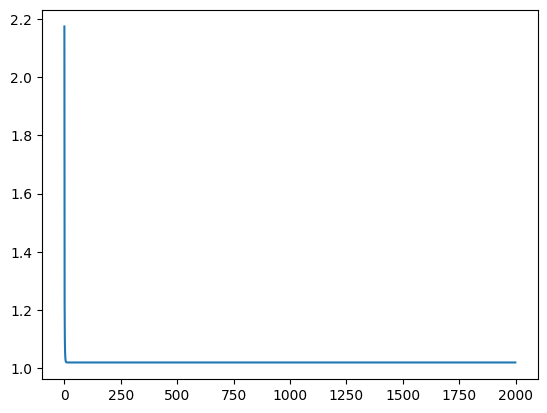

In [12]:
torch.manual_seed(420)

train_loop(
    TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2, activation_layer=nn.ReLU),
    list(range(0, 1 + _EPOCHS)),
    partial(torch.optim.SGD, lr=0.2),
    mse_loss_fn,
    DataLoader(xor_2d_dataset, batch_size=1, shuffle=False),
    None,
    Logger(visual_period=_EPOCHS),
)

In [13]:

valid_loader = DataLoader(xor_2d_dataset, batch_size=len(xor_2d_dataset), shuffle=False)
[[x, y]] = list(valid_loader)
np.vstack([model(x).detach().numpy().squeeze(), y.numpy()]).T

array([[ 2.3841858e-07,  0.0000000e+00],
       [ 9.9999988e-01,  1.0000000e+00],
       [ 9.9999988e-01,  1.0000000e+00],
       [-1.1920929e-07,  0.0000000e+00]], dtype=float32)

###



## Things to investigate further
- model initialization
- sgd algorithms
- lr effect
- harder problems
- visualizing solution (check out neurons graph here - https://courses.cs.washington.edu/courses/cse446/18wi/sections/section8/XOR-Pytorch.html)